# Dask: a flexible library for parallel computing in Python.

Dask is composed of two parts:

- Dynamic task scheduling optimized for computation. This is similar to Airflow, Luigi, Celery, or Make, but optimized for interactive computational workloads.
- “Big Data” collections like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments. These parallel collections run on top of dynamic task schedulers.

Many classes of problems cannot fit on a single computer or compute node. 
Some require more memory to process very large datasets, or could simply benefit from being spread across multiple compute nodes. 
One tool that can span from laptops to large clusters is `dask` (https://docs.dask.org/en/stable/), which can be installed via `conda`.

In [1]:
import dask.dataframe as dd
import dask.array as da

In [2]:
import numpy as np

In [3]:
data = np.random.normal(size=100000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [4]:
a[:50, 200]

dask.array<getitem, shape=(50,), dtype=float64, chunksize=(50,), chunktype=numpy.ndarray>

In [5]:
a[:50, 100].compute()

array([ 0.53110519, -0.20630848,  0.86135369, -2.53058261,  0.05613048,
        0.73843746,  0.07454317,  0.18544545,  0.39059709, -0.62749598,
        0.76903369,  0.15407196,  0.39892987,  0.30572936,  0.75201458,
        2.56208989, -0.18229236,  1.04304357,  0.3933149 ,  1.06380092,
        2.32063703, -0.8440662 , -0.58644984,  0.21516729,  1.20438312,
        0.69182351, -0.13062307, -2.16527849, -1.01857676,  1.13866001,
        0.58058512,  1.16493861,  0.14532251,  2.24680737, -1.08121493,
       -0.28481367, -0.12552127, -0.65926683, -0.93749229, -1.43488055,
       -0.15603512, -0.50718265,  1.05689281, -0.58296284,  0.22841115,
       -0.74631601, -0.22559469,  0.91092284,  1.06234181, -0.78437375])

In [6]:
a.mean().compute()

np.float64(0.003895638930160445)

## Dask Distributed with Slurm

In [7]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

In [8]:
# Define single unit of the Dask Distributed "Cluster"
cluster = SLURMCluster(queue='admintest', cores=1, memory="20GB")

# Scale up the cluster to have 10 members
cluster.scale(12)

# Initialize the "client" so that the script is connected to the Cluster
client = Client(cluster)


2025-12-16 16:30:38,874 - distributed.dashboard.components.scheduler - ERROR - 'chunk-b21e8bc372f8073ddb69417ad50399e5'
Traceback (most recent call last):
  File "/nfs/roberts/project/support/tl397/hpp/.venv/lib/python3.12/site-packages/distributed/utils.py", line 829, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/nfs/roberts/project/support/tl397/hpp/.venv/lib/python3.12/site-packages/distributed/dashboard/components/scheduler.py", line 2641, in update_layout
    x = max(xs[dep] for dep in dependencies[tg]) + 1
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/nfs/roberts/project/support/tl397/hpp/.venv/lib/python3.12/site-packages/distributed/dashboard/components/scheduler.py", line 2641, in <genexpr>
    x = max(xs[dep] for dep in dependencies[tg]) + 1
            ~~^^^^^
KeyError: 'chunk-b21e8bc372f8073ddb69417ad50399e5'
2025-12-16 16:30:38,876 - distributed.dashboard.components.scheduler - ERROR - 'chunk-b21e8bc372f8073ddb69417ad5039

In [9]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.18.20.8:8787/status,
Dashboard: http://10.18.20.8:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.18.20.8:37931,Workers: 0
Dashboard: http://10.18.20.8:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
data = np.random.normal(size=200000000).reshape(40000, 5000)
a = da.from_array(data, chunks=(2000, 1000))
a

dask.array<array, shape=(40000, 5000), dtype=float64, chunksize=(2000, 1000), chunktype=numpy.ndarray>

In [11]:
a.std().compute()

/nfs/roberts/project/support/tl397/hpp/.venv/lib/python3.12/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of size 1.49 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


np.float64(1.000008574543469)

## Example 3: NYC Taxi Data

- Collected data from all taxi and ride-share trips
- Very large data sets, too big to work with all at once on a single computer
- Let's use `dask` to explore some facets of the data


In [12]:
import glob
import matplotlib.pyplot as plt

In [13]:
yellow_cab = glob.glob('../taxi/yellow_tripdata_2022-*parquet')
ride_share = glob.glob('../taxi/fhvhv_tripdata_2022-*parquet')


In [14]:
yc = dd.read_parquet(yellow_cab)
rs = dd.read_parquet(ride_share) 


In [15]:
yc = yc[(yc.fare_amount > 0)]
rs = rs[(rs.base_passenger_fare > 0)]


### Question: Do people tip cabs or Ubers/Lyfts better?

In [16]:
h_yc, bins = da.histogram(np.divide(yc.tip_amount, yc.fare_amount), bins=200, range=[0.01, 100])
h_rs, bins = da.histogram(np.divide(rs.tips, rs.base_passenger_fare), bins=200, range=[0.01, 100])


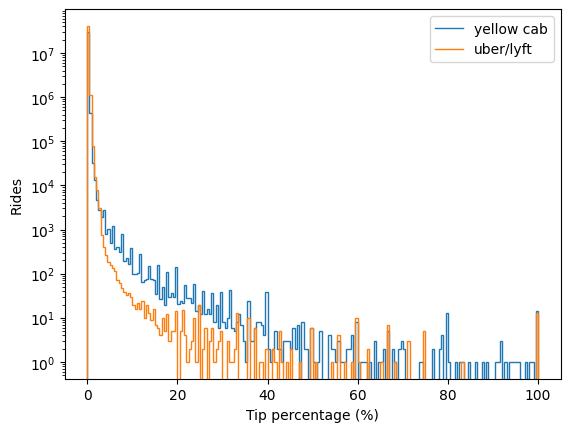

In [17]:
plt.subplots(1,1)
plt.stairs(h_yc, bins, label="yellow cab")
plt.stairs(h_rs, bins, label="uber/lyft")

plt.yscale('log');
plt.ylabel('Rides');
plt.xlabel('Tip percentage (%)');
plt.legend();

### Mean tip percentage

In [18]:
print(f"Yellow Cab: {100*yc.tip_amount.divide(yc.fare_amount).mean().compute():.2f}%")

Yellow Cab: 22.52%


In [19]:
print(f"Ride-share: {100*rs.tips.divide(rs.base_passenger_fare).mean().compute():.2f}%")

Ride-share: 4.40%


## Key Take-aways
1. Dask is able to orchestrate lots of parallel workers, either locally or across the cluster
2. It's easier to not tip when it's on an app?
